## Import libraries

In [12]:
import math
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.kalman import ExtendedKalmanFilter
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import matplotlib.ticker as ticker
import math
# Set the font size for all elements on the plot
plt.rcParams.update({'font.size': 14})


## ECEF Conversion

In [13]:
import math

# Function to convert latitude, longitude, and height to ECEF coordinates
def convert_to_ecef(lat, lon, height):
    a = 6378137.0  # semi-major axis of the WGS84 ellipsoid in meters
    f = 1 / 298.257223563  # flattening of the WGS84 ellipsoid
    
    # Convert latitude and longitude from degrees to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    
    # Compute auxiliary values
    sin_lat = math.sin(lat_rad)
    cos_lat = math.cos(lat_rad)
    sin_lon = math.sin(lon_rad)
    cos_lon = math.cos(lon_rad)
    
    # Compute the first eccentricity squared
    e2 = f * (2 - f)
    
    # Compute prime vertical radius of curvature
    N = a / math.sqrt(1 - e2 * sin_lat ** 2)
    
    # Compute ECEF coordinates
    x = (N + height) * cos_lat * cos_lon
    y = (N + height) * cos_lat * sin_lon
    z = ((1 - e2) * N + height) * sin_lat
    
    return x, y, z


## ENU Conversion

In [14]:

# Function to convert ECEF to ENU
def ecef_to_enu(x, y, z, ref_x, ref_y, ref_z):
    # Calculate displacement vector
    dx = x - ref_x
    dy = y - ref_y
    dz = z - ref_z
    
    # Convert reference point to ENU
    phi = np.arctan2(ref_z, np.sqrt(ref_x**2 + ref_y**2))
    lam = np.arctan2(ref_y, ref_x)
    
    # Convert displacement vector to ENU
    east = -np.sin(lam) * dx + np.cos(lam) * dy
    north = -np.sin(phi) * np.cos(lam) * dx - np.sin(phi) * np.sin(lam) * dy + np.cos(phi) * dz
    up = np.cos(phi) * np.cos(lam) * dx + np.cos(phi) * np.sin(lam) * dy + np.sin(phi) * dz
    
    return east, north, up

# R-squared Calcculation
def calculate_r_squared(original, estimated):
    original = np.array(original)
    estimated = np.array(estimated)
    mean_original = np.mean(original)
    ss_total = np.sum((original - mean_original) ** 2)
    ss_res = np.sum((original - estimated) ** 2)
    return 1 - (ss_res / ss_total)

## Reading file

In [15]:

# Read the ASCII file
file_path = "NO RTK NMUS22160001B_2024-03-27_07-41-34_BESTPOS.ASCII"
with open(file_path, 'r') as file:
    data = file.readlines()
print(len(data))
# Initialize lists to store parsed data
latitudes = []
longitudes = []
heights = []
num_svs=[]
num_sol_svs=[]
percentage_changes=[]
# Iterate through each line in the file
for line in data:
    # Split the line into log header and fields
    log_header, fields = line.split(';')
    log_header = log_header.split(',')    
    # Split the fields into individual data points
    fields = fields.split(',')
    
    # Extracting relevant data (latitude, longitude, and height)
    lat = float(fields[2])
    lon = float(fields[3])
    hgt = float(fields[4])
    num_sv = int(fields[13])
    num_sol_sv = int(fields[14])

    # Store the parsed data in lists
    latitudes.append(lat)
    longitudes.append(lon)
    heights.append(hgt)
    num_svs.append(num_sv)
    num_sol_svs.append(num_sol_sv)
 # Calculate percentage change and append to list
    val = (num_sv - num_sol_sv) / num_sol_sv * 100
    percentage_changes.append(val)

1581


## Apply Kalman filter

no rtk_bestgnsspos_newfile
kf.P = np.diag([100, 100, 100])
kf.R = np.diag([0.7, 0.6, 0.4])
kf.Q = np.diag([0.01, 0.01, 0.01])

rtk_bestgnsspos_newfile
kf.P = np.diag([100, 100, 100])
kf.R = np.diag([0.008, 0.008, 0.008])
kf.Q = np.diag([0.01, 0.01, 0.01])

In [16]:

# Convert original latitude, longitude, and height to ENU coordinates
org_east, org_north, org_up = [], [], []
for i in range(len(latitudes)):
    if i > 0:  # Skip the first point since there's no preceding point
        ref_x, ref_y, ref_z = convert_to_ecef(latitudes[i-1], longitudes[i-1], heights[i-1])
        x, y, z = convert_to_ecef(latitudes[i], longitudes[i], heights[i])
        east, north, up = ecef_to_enu(x, y, z, ref_x, ref_y, ref_z)
        org_east.append(east)
        org_north.append(north)
        org_up.append(up)

def fx(x, dt):
    F = np.array([[1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0],  
                  [0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0],  
                  [0, 0, 1, 0, 0, dt, 0, 0, 0.5*dt**2],  
                  [0, 0, 0, 1, 0, 0, dt, 0, 0],  
                  [0, 0, 0, 0, 1, 0, 0, dt, 0],  
                  [0, 0, 0, 0, 0, 1, 0, 0, dt],  
                  [0, 0, 0, 0, 0, 0, 1, 0, 0],  
                  [0, 0, 0, 0, 0, 0, 0, 1, 0],  
                  [0, 0, 0, 0, 0, 0, 0, 0, 1]])
    return np.dot(F, x)


# Define the measurement function
def hx(x):
    return np.array([x[0], x[1], x[2]])

# Define the Kalman Filter
kf = KalmanFilter(dim_x=9, dim_z=3)

# Define the state transition matrix (constant velocity model)
dt = 0.05  # Assuming constant time step
kf.F = np.array([[1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0],  
                 [0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0],  
                 [0, 0, 1, 0, 0, dt, 0, 0, 0.5*dt**2],  
                 [0, 0, 0, 1, 0, 0, dt, 0, 0],  
                 [0, 0, 0, 0, 1, 0, 0, dt, 0],  
                 [0, 0, 0, 0, 0, 1, 0, 0, dt],  
                 [0, 0, 0, 0, 0, 0, 1, 0, 0],  
                 [0, 0, 0, 0, 0, 0, 0, 1, 0],  
                 [0, 0, 0, 0, 0, 0, 0, 0, 1]])

# Define the measurement matrix (identity matrix)
kf.H = np.eye(3, 9)

# Define the process noise covariance matrix
kf.Q = np.diag([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])  

# Define the measurement noise covariance matrix
kf.R = np.diag([0.7,0.6,0.4])  

# Initialize state and covariance
initial_state = np.array([latitudes[0], longitudes[0], heights[0], 0., 0., 0., 0., 0., 0.])
kf.x = initial_state
kf.P *= 100

# Initialize lists to store filtered data
filtered_latitudes_kf = []
filtered_longitudes_kf = []
filtered_heights_kf = []

# Iterate through measurements and perform filtering
for measurement in zip(latitudes, longitudes, heights):
    kf.predict()
    kf.update(measurement)
    
    # Extract filtered state
    filtered_state = kf.x

    # Store filtered data
    filtered_latitudes_kf.append(filtered_state[0])
    filtered_longitudes_kf.append(filtered_state[1])
    filtered_heights_kf.append(filtered_state[2])



# Convert original latitude, longitude, and height to ENU coordinates
org_east, org_north, org_up ,ecef_x, ecef_y, ecef_z= [], [], [], [], [],[]
for i in range(len(latitudes)):
    if i > 0:  # Skip the first point since there's no preceding point
        ref_x, ref_y, ref_z = convert_to_ecef(latitudes[i-1], longitudes[i-1], heights[i-1])
        ecef_x.append(ref_x)
        ecef_y.append(ref_y)
        ecef_z.append(ref_z)
        x, y, z = convert_to_ecef(latitudes[i], longitudes[i], heights[i])
        east, north, up = ecef_to_enu(x, y, z, ref_x, ref_y, ref_z)
        org_east.append(east)
        org_north.append(north)
        org_up.append(up)


# Convert filtered latitude, longitude, and height to ENU coordinates
filt_east, filt_north, filt_up ,kf_x,kf_y,kf_z = [], [], [],[],[],[]
for i in range(len(filtered_latitudes_kf)):
    if i > 0:  # Skip the first point since there's no preceding point
        ref_x, ref_y, ref_z = convert_to_ecef(filtered_latitudes_kf[i-1], filtered_longitudes_kf[i-1], filtered_heights_kf[i-1])
        kf_x.append(ref_x)
        kf_y.append(ref_y)
        kf_z.append(ref_z)
        x, y, z = convert_to_ecef(filtered_latitudes_kf[i], filtered_longitudes_kf[i], filtered_heights_kf[i])
        east, north, up = ecef_to_enu(x, y, z, ref_x, ref_y, ref_z)
        filt_east.append(east)
        filt_north.append(north)
        filt_up.append(up)

print("orgeast_std",np.std(org_east))
print("orgnorth_std",np.std(org_north))
print("filteast_std",np.std(filt_east))
print("filtnorth_std",np.std(filt_north))
print("orgeast_mean",np.mean(org_east))
print("orgnorth_mean",np.mean(org_north))
print("filteast_mean",np.mean(filt_east))
print("filtnorth_mean",np.mean(filt_north))

orgeast_std 0.13467333375954468
orgnorth_std 0.22999050238364932
filteast_std 0.12273748074335349
filtnorth_std 0.2287511500296182
orgeast_mean 4.6130625572435827e-05
orgnorth_mean 0.0006280572900182353
filteast_mean 3.843915297574103e-05
filtnorth_mean 0.000565020662652851


## plot

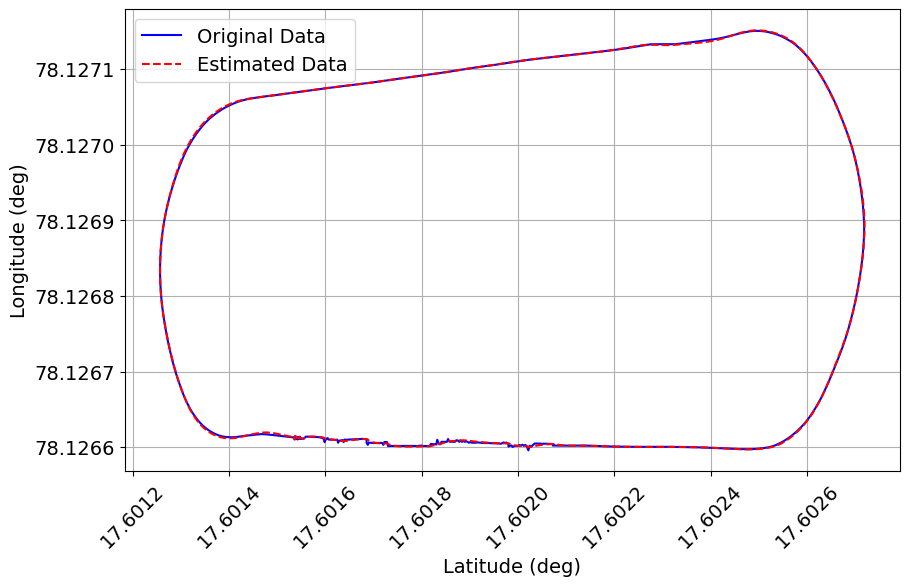

In [17]:
# Plot the original and estimated data
plt.figure(figsize=(10, 6))
plt.plot(latitudes, longitudes,'b', label='Original Data')
plt.plot(filtered_latitudes_kf, filtered_longitudes_kf,'r--', label='Estimated Data')
plt.xlabel('Latitude (deg)')
plt.ylabel('Longitude (deg)')
# plt.title('Original vs. Estimated Data')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.show()




## Before applying Kalman filter

In [18]:
org_eas_std=np.std(org_east)
org_nor_std=np.std(org_north)
org_up_std=np.std(org_up)
org_rms=math.sqrt(org_eas_std**2+org_nor_std**2)
org_twodrms=2*org_rms
org_cep =0.562 * org_eas_std + 0.615 * org_nor_std 
org_mrse_3d=math.sqrt(org_eas_std**2+org_nor_std**2+org_up_std**2)
org_sep_3d=0.51*org_mrse_3d
print("org_cep",org_cep)
print("org_rms",org_rms)
print("org_2drms",org_twodrms)
print("org_mrse_3d",org_mrse_3d)
print("org_sep_3d",org_sep_3d)

org_cep 0.21713057253880846
org_rms 0.26651930138846064
org_2drms 0.5330386027769213
org_mrse_3d 0.275174624863036
org_sep_3d 0.14033905868014837


## After applying kalman filter

In [19]:

mod_eas_std=np.std(filt_east)
mod_nor_std=np.std(filt_north)
mod_up_std=np.std(filt_up)
val=mod_eas_std/mod_nor_std
mod_rms=math.sqrt(mod_eas_std**2+mod_nor_std**2)
mod_twodrms=2*mod_rms
mod_cep =0.562 * mod_eas_std + 0.615 * mod_nor_std 
mod_mrse_3d=math.sqrt(mod_eas_std**2+mod_nor_std**2+mod_up_std**2)
mod_sep_3d=0.51*mod_mrse_3d

percentage_improvement = (1 - (mod_twodrms / org_twodrms)) * 100
print("percentage_improvement",percentage_improvement)
print("mod_cep",mod_cep)
print("mod_rms",mod_rms)
print("mod_2drms",mod_twodrms)
print("mod_mrse_3d",mod_mrse_3d)
print("mod_sep_3d",mod_sep_3d)

r_squared_lat = calculate_r_squared(latitudes, filtered_latitudes_kf)
r_squared_lon = calculate_r_squared(longitudes,filtered_longitudes_kf)
print("R-squared(lat)",r_squared_lat)
print("R-squared(long)",r_squared_lon)



percentage_improvement 2.5965934394132306
mod_cep 0.20966042144597985
mod_rms 0.2595988786938379
mod_2drms 0.5191977573876758
mod_mrse_3d 0.2605182767346836
mod_sep_3d 0.13286432113468863
R-squared(lat) 0.9999980693834875
R-squared(long) 0.999984909965084


## Extended kalman filter code

In [20]:
# EKF last code 
# Define the state transition function

def f(x, dt):
    # Assuming a constant velocity model
    return x

# Define the measurement function
def h(x):
    return x

# Define the Jacobian of the measurement function
def HJacobian(x):
    return np.eye(3)  # Identity matrix since measurement function is identity

# Initialize the Extended Kalman Filter
ekf = ExtendedKalmanFilter(dim_x=3, dim_z=3)

# Set the state transition function and measurement function for the filter
ekf.x = np.array([latitudes[0], longitudes[0], heights[0]])
ekf.F = np.eye(3)  # State transition matrix
ekf.H = np.eye(3)  # Measurement matrix

# Initialize the state covariance matrix
ekf.P *= 100.0

# Initialize the measurement covariance matrix
ekf.R = np.diag([0.7, 0.6, 0.4])

# Initialize the process noise covariance matrix
ekf.Q = np.diag([0.01, 0.01, 0.01])

# Initialize the time step
dt = 0.05

# Apply the Extended Kalman Filter to the latitude, longitude, and height data
filtered_states = []
for measurement in zip(latitudes, longitudes, heights):
    ekf.predict()
    # Update Step
    ekf.update(np.array(measurement), HJacobian=HJacobian, Hx=h)      
    filtered_states.append(ekf.x)

# Extract filtered latitudes, longitudes, and heights
filtered_latitudes_ekf = [state[0] for state in filtered_states]
filtered_longitudes_ekf = [state[1] for state in filtered_states]
filtered_heights_ekf = [state[2] for state in filtered_states]

# Convert filtered latitude, longitude, and height to ENU coordinates
filt_east_ekf, filt_north_ekf, filt_up_ekf,ekf_x,ekf_y,ekf_z = [], [], [],[],[],[]
for i in range(len(filtered_latitudes_ekf)):
    if i > 0:  # Skip the first point since there's no preceding point
        ref_x, ref_y, ref_z = convert_to_ecef(filtered_latitudes_ekf[i-1], filtered_longitudes_ekf[i-1], filtered_heights_ekf[i-1])
        ekf_x.append(ref_x)
        ekf_y.append(ref_y)
        ekf_z.append(ref_z)
        x, y, z = convert_to_ecef(filtered_latitudes_ekf[i], filtered_longitudes_ekf[i], filtered_heights_ekf[i])
        east, north, up = ecef_to_enu(x, y, z, ref_x, ref_y, ref_z)
        filt_east_ekf.append(east)
        filt_north_ekf.append(north)
        filt_up_ekf.append(up)


## After ekf filtering

In [21]:
mod_eas_std=np.std(filt_east_ekf)
mod_nor_std=np.std(filt_north_ekf)
mod_up_std=np.std(filt_up_ekf)
val=mod_eas_std/mod_nor_std
mod_rms=math.sqrt(mod_eas_std**2+mod_nor_std**2)
mod_twodrms=2*mod_rms
mod_cep =0.562 * mod_eas_std + 0.615 * mod_nor_std 
mod_mrse_3d=math.sqrt(mod_eas_std**2+mod_nor_std**2+mod_up_std**2)
mod_sep_3d=0.51*mod_mrse_3d
percentage_improvement = (1 - (mod_twodrms / org_twodrms)) * 100
print("ekf")
print("percentage_improvement_ekf",percentage_improvement)
print("mod_cep",mod_cep)
print("mod_rms",mod_rms)
print("mod_2drms",mod_twodrms)
print("mod_mrse_3d",mod_mrse_3d)
print("mod_sep_3d",mod_sep_3d)

r_squared_lat = calculate_r_squared(latitudes, filtered_latitudes_kf)
r_squared_lon = calculate_r_squared(longitudes,filtered_longitudes_kf)
print("R-squared(lat)",r_squared_lat)
print("R-squared(long)",r_squared_lon)



ekf
percentage_improvement_ekf 3.0913199015844106
mod_cep 0.20840060854923356
mod_rms 0.2582803371830754
mod_2drms 0.5165606743661508
mod_mrse_3d 0.2587228236342751
mod_sep_3d 0.1319486400534803
R-squared(lat) 0.9999980693834875
R-squared(long) 0.999984909965084


## Graphs Plotting

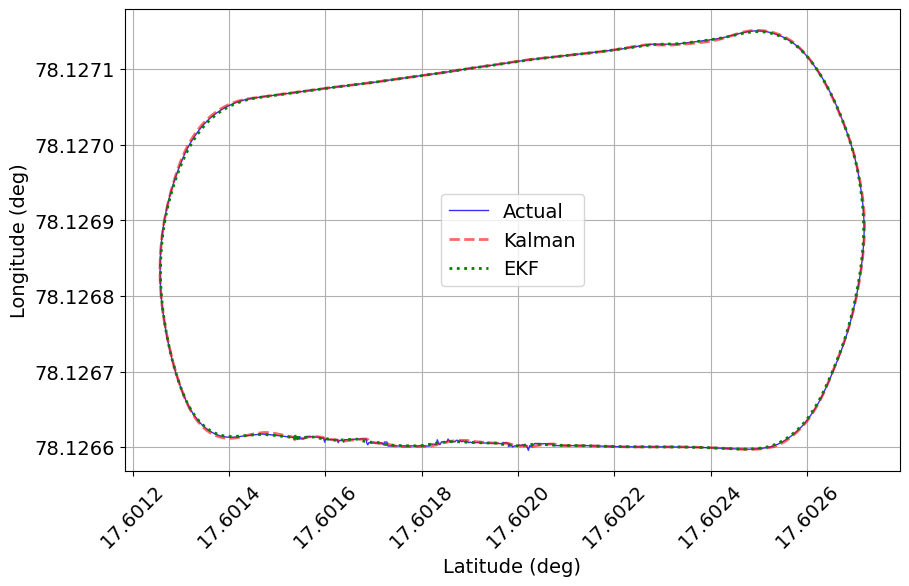

In [22]:
import matplotlib.pyplot as plt

# Plot all the filtered data in a single plot with legends
plt.figure(figsize=(10, 6))

plt.plot(latitudes,longitudes,'b', label='Actual', linewidth=1, alpha=0.8)
plt.plot(filtered_latitudes_kf,filtered_longitudes_kf,'r--',label='Kalman', linewidth=2, alpha=0.6)
plt.plot(filtered_latitudes_ekf,filtered_longitudes_ekf,'g:',label='EKF',  linewidth=2, alpha=1)

plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.xlabel('Latitude (deg)')
plt.ylabel('Longitude (deg)')
# plt.title('Trajectory of autonomous car')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()